# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Regresija)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#Lasso-regresija)
    
    -[Ridge](#Rigde-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

# Vizualizacija podataka

In [3]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
df.shape

(1000, 8)

## Kategoričke značajke

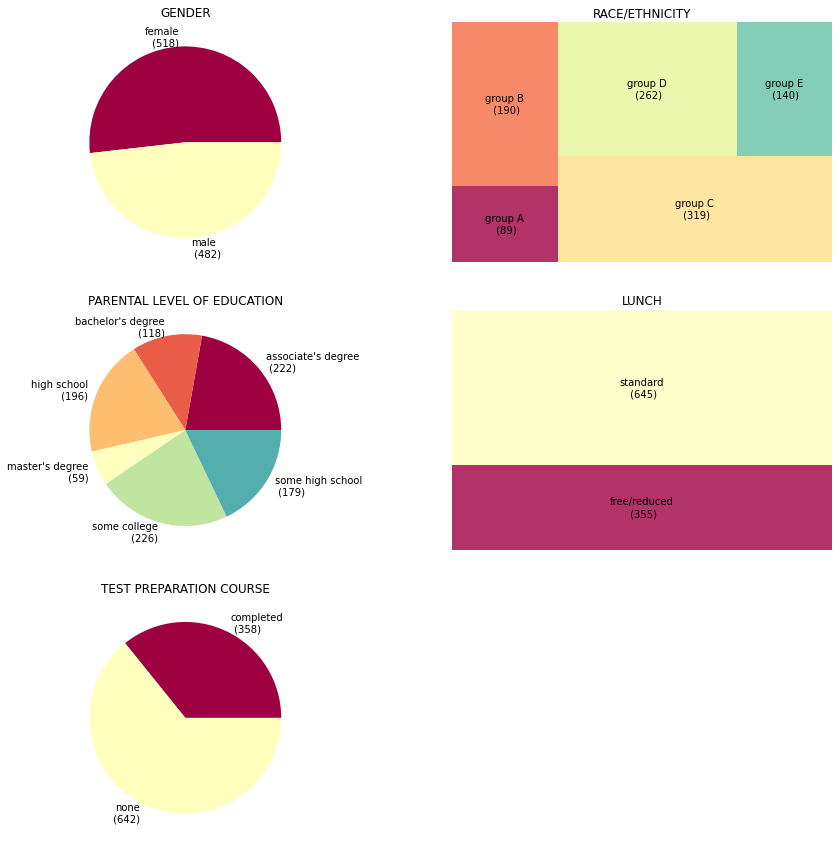

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Numeričke značajke 

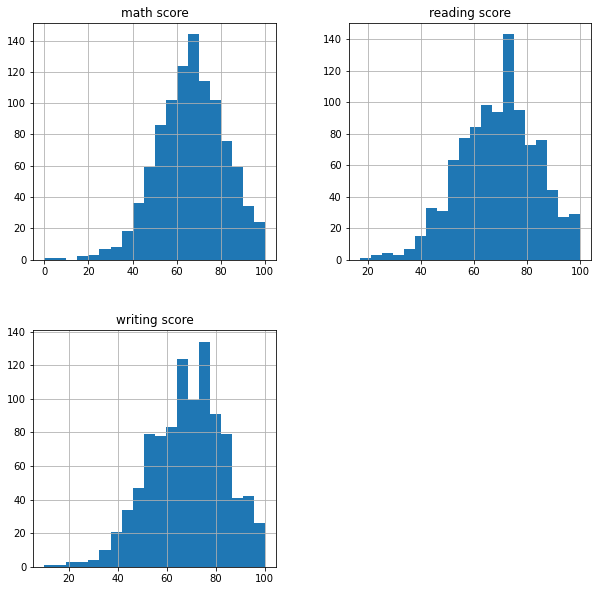

In [6]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

## Usporedba spola

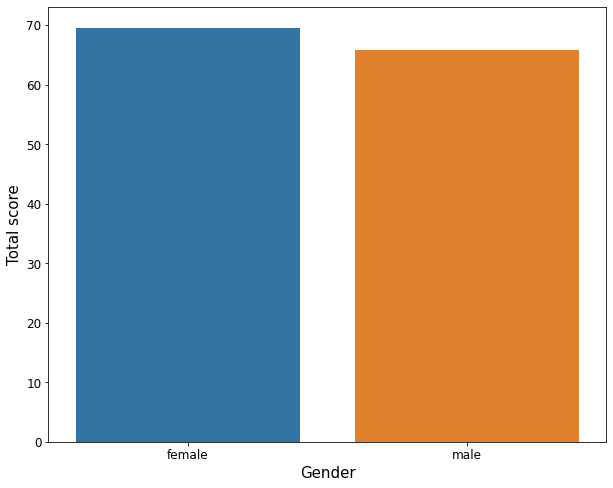

In [7]:
df['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
plt.figure(figsize = (10,8))
sns.barplot(data = df, x = 'gender', y = 'Total score', ci = False)
plt.xticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Total score', fontsize = 15)
plt.show()

## Utjecaj priprema za ispit na rezultate 

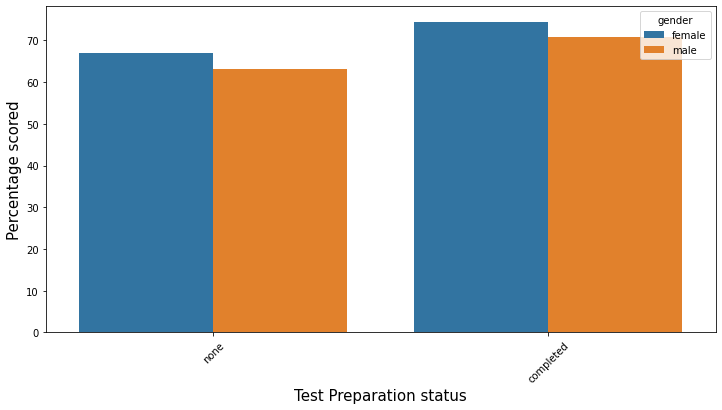

In [8]:
plt.figure(figsize = (12,6))
sns.barplot(data = df, x = 'test preparation course', y = 'Total score', hue = 'gender', ci = False)
plt.xlabel('Test Preparation status', fontsize = 15)
plt.xticks(rotation = 45)
plt.ylabel('Percentage scored', fontsize = 15)
plt.show()

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


## Label encoding

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [74]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to cn+hange our code in multiple places
    return pd.get_dummies(df, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })

df2 = one_hot_encoding(df)
#df2 = find_and_replace(df)

# jedan primjer kako nam sada izgledaju podaci u odnosu na prijašnje
#print(df.head())
print(df2.head())

   math score  reading score  writing score  Total score  gender  \
0          72             72             74        72.67       0   
1          69             90             88        82.33       0   
2          90             95             93        92.67       0   
3          47             57             44        49.33       1   
4          76             78             75        76.33       1   

   race/ethnicity_group B  race/ethnicity_group C  race/ethnicity_group D  \
0                       1                       0                       0   
1                       0                       1                       0   
2                       1                       0                       0   
3                       0                       0                       0   
4                       0                       1                       0   

   race/ethnicity_group E  parental level of education_bachelor's degree  \
0                       0                           

## Train Test Split 

Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [75]:
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

## Regresija


Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

## Linearna Regresija

In [76]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
#print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

Objasnjena varijanca = 0.20
R2 = 0.19
MSE = 166.77


## Lasso regresija